In [1]:
import os

import dask
import dask.array as da
import ipycytoscape
import graphviz
import xarray as xr
import numpy as np

In [2]:
data_path = '../data'

# Creating a `dask.array` from a `numpy.array`

In [3]:
# First a simple 3x3 numpy array
np_arr = np.array([
    [1,2,3],
    [4,5,6],
    [7,8,9]
])
np_arr

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [4]:
# And here using the dask.array.from_array function
# We also declare the shape of the chunks to be 1x1, and thus we will have 9 in total
dask_arr = da.from_array(np_arr, chunks=(1,1))
# Printing gives a nice representation of the current state of the data
dask_arr

dask.array<array, shape=(3, 3), dtype=int64, chunksize=(1, 1), chunktype=numpy.ndarray>

Taking the mean over all the columns (same as we do with `numpy`), but the result is a Future, not the data itself. It does now show the resulting number of chunks and the dimensionality of the new data.

In [5]:
col_means = dask_arr.mean(axis=0)
col_means

dask.array<mean_agg-aggregate, shape=(3,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>

Using `compute()`, we can now execute the task graph and get the data.

In [6]:
col_means.compute()

array([4., 5., 6.])

# Using `xarray`
Another common package for data manipulation. Particularly common with spatial data and working with NetCDF files. As it turns out, `xarray` can use either `numpy` or `dask` arrays as its backend. The latter allows us to make use of `dask`'s functionality in a new way.

In [7]:
# Opening multiple files into single object. Opening any file in the data directory with the given pattern
# Here I've decided to chunk the data only along the time dimension, in 365 unit chunks, which in this case is daily so a year per chunk.
precipitation = xr.open_mfdataset(os.path.join(data_path, 'pr*.nc4'), chunks=dict(time=365))

Now the object is an `xarray`

In [8]:
precipitation

<xarray.Dataset>
Dimensions:  (lon: 720, lat: 360, time: 7305)
Coordinates:
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * time     (time) datetime64[ns] 1991-01-01 1991-01-02 ... 2010-12-31
Data variables:
    pr       (time, lat, lon) float32 dask.array<chunksize=(365, 360, 720), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.6.6 (http://code.zmaw.de/p...
    Conventions:  CF-1.4
    comment:      GSWP3 global meteorological dataset processed for ISI-MIP2,...
    CDO:          Climate Data Operators version 1.6.6 (http://code.zmaw.de/p...
    version:      v1
    comment_PIK:  until official publish the data is only to be used for ISI-...

With a `Dask` backend, seen if you look at `.data`, which would traditionally just point to the values of a `numpy.array`

In [9]:
precipitation['pr'].data

dask.array<concatenate, shape=(7305, 360, 720), dtype=float32, chunksize=(365, 360, 720), chunktype=numpy.ndarray>

Here we can use `groupby` and `sum`, just as we would with `xarray` normally. Here though, execution won't happen until we call compute. Additionally, if we were using parallelization here,
`Dask` would speed this operation up.

In [10]:
annual_precip = precipitation.groupby('time.year').sum()
annual_precip

<xarray.Dataset>
Dimensions:  (lon: 720, lat: 360, year: 20)
Coordinates:
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * year     (year) int64 1991 1992 1993 1994 1995 ... 2006 2007 2008 2009 2010
Data variables:
    pr       (year, lat, lon) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.6.6 (http://code.zmaw.de/p...
    Conventions:  CF-1.4
    comment:      GSWP3 global meteorological dataset processed for ISI-MIP2,...
    CDO:          Climate Data Operators version 1.6.6 (http://code.zmaw.de/p...
    version:      v1
    comment_PIK:  until official publish the data is only to be used for ISI-...

See now that after `compute()`, the precipitation data is available and held in a simple `numpy.array`.

In [11]:
annual_precip.compute()

<xarray.Dataset>
Dimensions:  (lon: 720, lat: 360, year: 20)
Coordinates:
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * year     (year) int64 1991 1992 1993 1994 1995 ... 2006 2007 2008 2009 2010
Data variables:
    pr       (year, lat, lon) float32 0.004675 0.004675 ... 0.001018 0.001008
Attributes:
    CDI:          Climate Data Interface version 1.6.6 (http://code.zmaw.de/p...
    Conventions:  CF-1.4
    comment:      GSWP3 global meteorological dataset processed for ISI-MIP2,...
    CDO:          Climate Data Operators version 1.6.6 (http://code.zmaw.de/p...
    version:      v1
    comment_PIK:  until official publish the data is only to be used for ISI-...

# Dask Distributed
Contains functions for deploying workers to perform tasks in parallel. Learn more at their docs [here](https://distributed.dask.org/en/stable/).

In [12]:
from dask.distributed import Client
from dask.distributed import LocalCluster

`Client` will fire up workers. It implicitly calls `LocalCluster`, though you can be explicit by first creating a `LocalCluster` object, and supplying it manually, as is done here. This is where you can specify the details about the workers you want.

By default, threading is the preferred, which is set by `processes=False`. Here we've instead chosen to fire up Python processes, 8 in total, each with 1 thread.

Here we also display the `Client` object, which will give us info about our deployment, as well as provide a link to the Dask dashboard.

In [13]:
cluster = LocalCluster(n_workers=8, processes=True, threads_per_worker=1)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:58670,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:58733,Total threads: 1
Dashboard: http://127.0.0.1:58735/status,Memory: 2.00 GiB
Nanny: tcp://127.0.0.1:58680,


Important to close your client if doing it this way. Below is a preferred method for initiating client.

In [14]:
client.close()

# Map Blocks, Delayed and Other Dask Functions

### Map Blocks

`dask.array.map_blocks()` allows you to perform the same function on each chunk of you data. This is another delayed function, so it adds to the Dask task graph. This means when you call `map_blocks()`, it will add it to the task list, and also test it out with empty data to make sure it is successful, and retrieve things like data type and shape information. Not until you `compute()` will you have access to the resulting data. This is great because again, it makes use of the scheduler to run tasks in parallel, and to manage memory.

In the below example, we compute the element-wise square root of the 3x3 matrix previously created. In this very overkill example, each element is sent to its own worker, in this case a process with 1 thread.
$$
\begin{vmatrix}
    1 & 2 & 3 \\
    4 & 5 & 6 \\
    7 & 8 & 9
\end{vmatrix} \rightarrow
\begin{vmatrix}
    \sqrt{1} & \sqrt{2} & \sqrt{3} \\
    \sqrt{4} & \sqrt{5} & \sqrt{6} \\
    \sqrt{7} & \sqrt{8} & \sqrt{9}
\end{vmatrix}
$$

Note that below we explicitly set processes to false. This isn't necessary but to make a point about when you may want to use threading over processing and vice-versa. For one, this example is tiny, and thus it's not worth the added overhead of firing up a bunch of Python processes. In addition, when the functions you call unlock the GIL, you can actually make use of multi-threading. This happens to be the case with many numpy operations.

In [15]:
# Processes = False, don't need all the overhead for such a small computation, and one that unlocks the GIL
with LocalCluster(processes=False) as cluster, Client(cluster) as client:
    root_arr = da.map_blocks(np.sqrt, dask_arr).compute()

root_arr

/Users/prim232/opt/miniconda3/envs/ETTF-Dask/lib/python3.10/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 58742 instead
  warnings.warn(


array([[1.        , 1.41421356, 1.73205081],
       [2.        , 2.23606798, 2.44948974],
       [2.64575131, 2.82842712, 3.        ]])

You can also pass multiple dask arrays into map blocks when they have the same number of chunks. In the below example we'll create an array which is the inverse of our previous dask array, and perform element-wise product in parallel to get a matrix of ones.

$$
\begin{vmatrix}
    1 & 2 & 3 \\
    4 & 5 & 6 \\
    7 & 8 & 9
\end{vmatrix} \overset{\text{element wise}}{\times}
\begin{vmatrix}
    \frac{1}{1} & \frac{1}{2} & \frac{1}{3} \\
    \frac{1}{4} & \frac{1}{5} & \frac{1}{6} \\
    \frac{1}{7} & \frac{1}{8} & \frac{1}{9}
\end{vmatrix} =
\begin{vmatrix}
    1 & 1 & 1 \\
    1 & 1 & 1 \\
    1 & 1 & 1
\end{vmatrix}
$$

In [16]:
# Inverse array chunked identically to the original
inv_arr = 1 / np.arange(1,10).reshape(3,3)
inv_arr = da.from_array(inv_arr, chunks=(1,1))

In [17]:
# Product function
def prod(x, y):
    return x * y

In [18]:
# Computing result by supplying both arrays as input
with LocalCluster(processes=False) as cluster, Client(cluster) as client:
    ones = da.map_blocks(prod, dask_arr, inv_arr).compute()

ones

/Users/prim232/opt/miniconda3/envs/ETTF-Dask/lib/python3.10/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 58746 instead
  warnings.warn(


array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

### Delayed
For turning your functions into those which can add to the task graph and be executed lazily. See the docs for delayed [here](https://docs.dask.org/en/stable/delayed.html).

Here's some simple functions written in standard Python

In [19]:
def inc(x):
    return x + 1

def double(x):
    return x * 2

def add(x, y):
    return x + y

Here's what happens when executing them in standard Python, computing in real time.

In [20]:
a = inc(1)
b = inc(2)
c = add(a, b)
c

5

And here we apply `delayed` and get a `Delayed` object as output. We have not yet computed the result.

In [21]:
a = dask.delayed(inc)(1)
b = dask.delayed(inc)(2)
c = dask.delayed(add)(a, b)
c

Delayed('add-059a3b68-37e4-4d98-815e-84a9e0167a30')

Here we compute the result, and see we get the same answer as with standard Python.

In [22]:
c.compute()

5

We can also visualize the task graph. This requires [graphviz](https://www.graphviz.org/), or [cytoscape](https://pypi.org/project/ipycytoscape/), or some other engine to run.

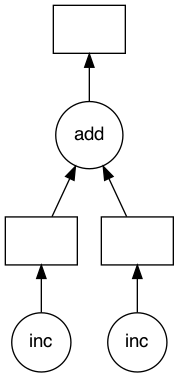

In [23]:
c.visualize()

The `delayed` decorator can be used to turn your functions into delayed functions, which can make using them cleaner, and allow for parallel code.

In [24]:
@dask.delayed
def inc(x):
    return x + 1

@dask.delayed
def double(x):
    return x * 2

@dask.delayed
def add(x, y):
    return x + y

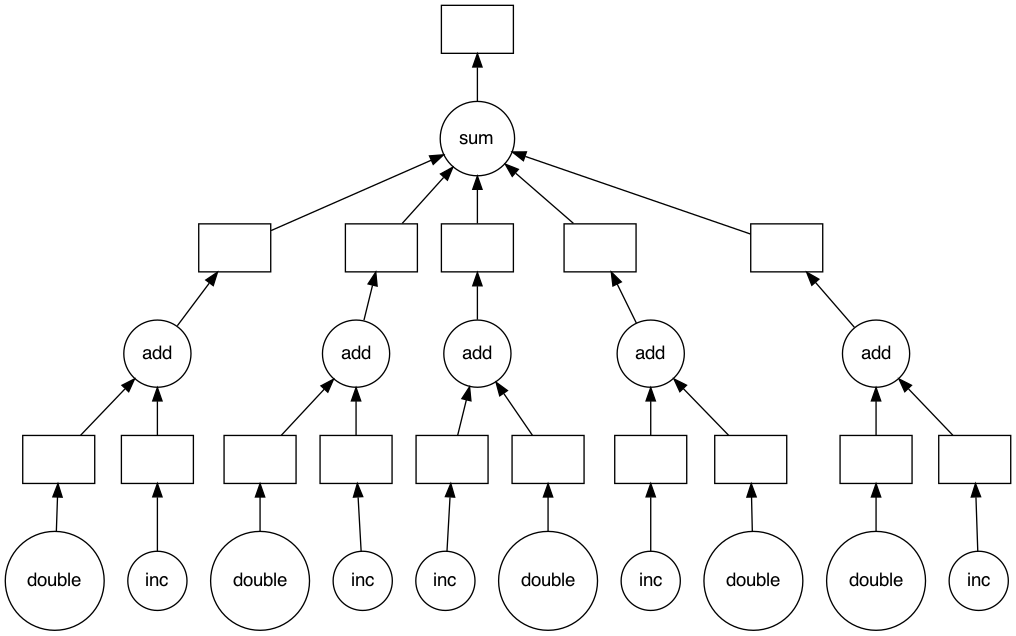

In [25]:
data = [1, 2, 3, 4, 5]

output = []
for d in data:
    a = inc(d)
    b = double(d)
    c = add(a, b)
    output.append(c)

total = dask.delayed(sum)(output)
total.visualize()

In [26]:
with LocalCluster() as cluster, Client(cluster) as client:
    total = total.compute()

total

/Users/prim232/opt/miniconda3/envs/ETTF-Dask/lib/python3.10/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 58761 instead
  warnings.warn(


50

### Other
I won't go into detail, but there are other functions for different use cases including but not limited to:

* [`blockwise`](https://docs.dask.org/en/latest/generated/dask.array.blockwise.html) - another way for applying functions over dask arrays
* [`apply_ufunc`](https://docs.xarray.dev/en/stable/generated/xarray.apply_ufunc.html) - For use with `xarray`
* [`map_partitions`](https://docs.dask.org/en/stable/generated/dask.dataframe.DataFrame.map_partitions.html) - The `dask.dataframe` equivalent of `map_blocks`